## Goal
As a first pass at developing a machine learning model to predict California wildfires I will evaluate and tune several different gradient boosting algorithms. The procedure will be as follows:

1. Determine the best gradient boosting for the data
2. Determine the best scoring function/metric for optimization
3. Tune model hyperparameters
4. Investigate feature importance and possibly trim/apply dimensionality reduction techniques to the data

There are two anticipated issues which will need to be dealt with first:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)

Future goals are to add several more factors from various data sources including: elevation, population density, time since last fire and total fires.

**Imports and notebook setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from random import randint
from time import time
from statistics import mean
from scipy import stats
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from IPython.display import display_markdown
from scipy.interpolate import griddata

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

<Figure size 432x288 with 0 Axes>

**Variable definitions**

In [2]:
data_file = '../data/training_data/1992-1997_training_data.csv'
rand_seed = 123

# sample ~1% of total data. Also, there are ~370000 gnition observations total,
# my feeling is we want to keep our sample size below that using 1% of the total
# data means we will end up using about 10% of ignitions in each sample
data_sample_size = 1000

test_train_split_ratio = 0.3 
classifier_jobs = 14
optimization_jobs = 1
max_jobs = classifier_jobs * optimization_jobs
num_trials = 5
search_iterations = 100
search_scoring_func = make_scorer(average_precision_score)
plot_grid_resolution = 100
contourf_levels = 100

**Functions**

In [3]:
def k_random_sample(data, k):
    n = len(data)
    
    indices = random.sample(range(0, n), k)
    
    return data.iloc[indices]

def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_train_split_ratio, 
        random_state=rand_seed
    )

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def sample_data(data, data_sample_size):

    # split positive and negative datsets up
    ignitions = data[data['ignition'] > 0]
    no_ignitions = data[data['ignition'] == 0]
    
    # due to the moving average we will have some positive observations with
    # fractional ignition values
    ignitions = ignitions.assign(ignition=1)
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, data_sample_size)
    ignitions_sample = k_random_sample(ignitions, data_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data
    
def calc_false_neg_pos_rate(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))

    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]

    false_neg_rate = FN / (FN + TN)
    false_pos_rate = FP / (FP + TN)
    
    return false_neg_rate, false_pos_rate

def compare_algorithms(
    classifiers, 
    model_descriptions,
    num_trials,
    data_moving_avg,
    data_sample_size
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = ['Classifier', 'n', 'Training score +/- STD','Test score +/- STD','False positive rate +/- STD','False negative rate +/- STD']
    model_scores = pd.DataFrame(columns=model_scores_columns)    
    
    # Loop over the diffrent classifiers
    for classifier, description in zip(classifiers, model_descriptions):
        train_scores = []
        test_scores = []
        false_pos_rates = []
        false_neg_rates = []
        
        for i in range(num_trials):
            # Resample and train-test split data
            sampled_data = sample_data(data_moving_avg, data_sample_size)
            targets = sampled_data['ignition']
            data = sampled_data.drop(['ignition'], axis=1)
            x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)
        
            # Initalize and train model on sampled data
            model = classifier
            model.fit(x_train, y_train)

            train_scores.append(average_precision_score(model.predict(x_train), y_train))
            test_scores.append(average_precision_score(model.predict(x_test), y_test))
            false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, x_test, y_test)
            false_neg_rates.append(false_neg_rate)
            false_pos_rates.append(false_pos_rate)
            
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        avg_false_neg_rate = mean(false_neg_rates)
        avg_false_pos_rate = mean(false_pos_rates)
        
        std_train_score = np.std(train_scores)
        std_test_score = np.std(test_scores)
        std_false_neg_rate = np.std(false_neg_rates)
        std_false_pos_rate = np.std(false_pos_rates)
        
        model_scores = model_scores.append(pd.Series([
            description,
            num_trials,
            '{} +/- {}'.format(np.round(avg_train_score,2), np.round(std_train_score,3)),
            '{} +/- {}'.format(np.round(avg_test_score,2), np.round(std_test_score,3)),
            '{} +/- {}'.format(np.round(avg_false_pos_rate,2), np.round(std_false_pos_rate,3)),
            '{} +/- {}'.format(np.round(avg_false_neg_rate,2), np.round(std_false_neg_rate,3)),
        ], index=model_scores.columns), ignore_index=True)
        
        i += 1
        
    return model_scores
    
def test_scoring_functions(
    num_trials,
    scoring_functions, 
    data_moving_avg,
    data_sample_size,
    max_jobs
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = ['Scoring function', 'n', 'Training score +/- STD','Test score +/- STD','False positive rate +/- STD','False negative rate +/- STD']
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for scoring_function in scoring_functions:
        train_scores = []
        test_scores = []
        false_pos_rates = []
        false_neg_rates = []
        
        for i in range(num_trials):
            # Resample and train-test split data
            sampled_data = sample_data(data_moving_avg, data_sample_size)
            targets = sampled_data['ignition']
            data = sampled_data.drop(['ignition'], axis=1)
            x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)
            
            catboost_mod = CatBoostClassifier(
                thread_count = max_jobs,
                score_function = scoring_function
            )

            catboost_mod.fit(x_train, y_train, silent=True)

            train_scores.append(average_precision_score(catboost_mod.predict(x_train), y_train))
            test_scores.append(average_precision_score(catboost_mod.predict(x_test), y_test))
            false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
            false_neg_rates.append(false_neg_rate)
            false_pos_rates.append(false_pos_rate)
            
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        avg_false_neg_rate = mean(false_neg_rates)
        avg_false_pos_rate = mean(false_pos_rates)
        
        std_train_score = np.std(train_scores)
        std_test_score = np.std(test_scores)
        std_false_neg_rate = np.std(false_neg_rates)
        std_false_pos_rate = np.std(false_pos_rates)
        
        model_scores = model_scores.append(pd.Series([
            scoring_function,
            num_trials,
            '{} +/- {}'.format(np.round(avg_train_score,2), np.round(std_train_score,3)),
            '{} +/- {}'.format(np.round(avg_test_score,2), np.round(std_test_score,3)),
            '{} +/- {}'.format(np.round(avg_false_pos_rate,2), np.round(std_false_pos_rate,3)),
            '{} +/- {}'.format(np.round(avg_false_neg_rate,2), np.round(std_false_neg_rate,3)),
        ], index=model_scores.columns), ignore_index=True)
        
        i += 1

    return model_scores

def plot_relative_feature_importance(model, data, x_test, x_tick_size):
    importances = catboost_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.array(list(data))

    plt.figure(figsize=(20,10))
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=x_tick_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
    plt.title("Feature importance")
    plt.bar(range(x_test.shape[1]), importances[indices],
           color="darkblue", align="center")
    plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
    plt.xlim([-1, x_test.shape[1]])
    plt.xlabel("Feature")
    plt.ylabel("Relative importance")
    
    plt.show()
    
def tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
):
    model_scores_columns = ['Class weight', 'Training score','Test score','False positive rate','False negative rate']
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for class_weight in class_weights:
        catboost_mod = CatBoostClassifier(
            thread_count = (classifier_jobs * optimization_jobs),
            score_function = 'Cosine',
            scale_pos_weight = class_weight
        )

        catboost_mod.fit(x_train, y_train, silent=True)

        training_score = average_precision_score(catboost_mod.predict(x_train), y_train)
        test_score = average_precision_score(catboost_mod.predict(x_test), y_test)
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
        model_scores = model_scores.append(pd.Series([class_weight, np.round(training_score,2), np.round(test_score,2), np.round(false_pos_rate,2), np.round(false_neg_rate,2)], index=model_scores.columns), ignore_index=True)

    return model_scores

def plot_class_weight_tuning_results(model_scores):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    plt.subplots(1,2,figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.scatter(np.log10(model_scores['Class weight']), model_scores['False positive rate'], s=20, c='darkblue', label='False positive')
    plt.scatter(np.log10(model_scores['Class weight']), model_scores['False negative rate'], s=20, c='darkred', label='False negative')
    plt.legend(loc='upper left')
    plt.xlabel("Log 10 class weight")
    plt.ylabel("Rate")
    plt.title("Class weight and false prediction rates")

    plt.subplot(1, 2, 2)
    plt.scatter(np.log10(model_scores['Class weight']), model_scores['Training score'], s=20, c='darkblue', label='Training')
    plt.scatter(np.log10(model_scores['Class weight']), model_scores['Test score'], s=20, c='darkred', label='Test')
    plt.legend(loc='lower right');
    plt.xlabel("Log 10 class weight")
    plt.ylabel("Score")
    plt.title("Class weight and precision-recall score")

    plt.tight_layout()
    plt.show()
    

def train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = ['Scoring function', 'n', 'Training score +/- STD','Test score +/- STD','False positive rate +/- STD','False negative rate +/- STD']
    model_scores = pd.DataFrame(columns=model_scores_columns)

    train_scores = []
    test_scores = []
    false_pos_rates = []
    false_neg_rates = []
        
    for i in range(num_trials):
        # Resample and train-test split data
        sampled_data = sample_data(data_moving_avg, data_sample_size)
        targets = sampled_data['ignition']
        data = sampled_data.drop(['ignition'], axis=1)
        x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)

        catboost_mod = CatBoostClassifier(**known_params)
        catboost_mod.fit(x_train, y_train, silent=True)

        train_scores.append(average_precision_score(catboost_mod.predict(x_train), y_train))
        test_scores.append(average_precision_score(catboost_mod.predict(x_test), y_test))
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
        false_neg_rates.append(false_neg_rate)
        false_pos_rates.append(false_pos_rate)
        
        i += 1
            
    avg_train_score = mean(train_scores)
    avg_test_score = mean(test_scores)
    avg_false_neg_rate = mean(false_neg_rates)
    avg_false_pos_rate = mean(false_pos_rates)

    sem_train_score = stats.sem(train_scores)
    sem_test_score = stats.sem(test_scores)
    sem_false_neg_rate = stats.sem(false_neg_rates)
    sem_false_pos_rate = stats.sem(false_pos_rates)

    model_scores = model_scores.append(pd.Series([
        'Catboost with scoring function & class weight',
        num_trials,
        '{} +/- {}'.format(np.round(avg_train_score,2), np.round(sem_train_score,3)),
        '{} +/- {}'.format(np.round(avg_test_score,2), np.round(sem_test_score,3)),
        '{} +/- {}'.format(np.round(avg_false_pos_rate,2), np.round(sem_false_pos_rate,3)),
        '{} +/- {}'.format(np.round(avg_false_neg_rate,2), np.round(sem_false_neg_rate,3)),
    ], index=model_scores.columns), ignore_index=True)

    return model_scores

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize catboost classifier
    model = CatBoostClassifier(**known_params)

    # set up random search
    random_search = RandomizedSearchCV(
        model, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    best_model = random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return best_model, random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

## Data preparation

In [4]:
# read data
data = pd.read_csv(data_file, low_memory=False)

# set ignition to 0 for noxels with no fire
data['ignition'].fillna(0, inplace=True)

# count number of observations in each class
ignition_count = len(data[data["ignition"] == 1])
no_ignition_count = len(data) - ignition_count
print('Total observations: {:.1E}'.format(len(data)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

Total observations: 7.3E+06
Ignitions count: 3.7E+05
Non ignitions count: 6.9E+06


OK, so before we dig into this much farther, I am noticing an issue. For some fires we know the discovery time and some we do not. I can imagine a few ways of dealing with this:

1. Throw out fires for which we do not know the discovery time
2. Average everything at the day resolution level

I am leaning toward option two because:

1. Discovery time is not ignition time so the weather state during that exact hour may not be pertinent anyway - for example: what if the fire had already been burning for hours and the temperature had changed drastically?
2. The data is already skewed toward no ignition observations. I would rather not have to throw out even more fires. Also, doing so will mean that I have noxels where there was a fire which was not included in the dataset. 

Specific plan is to roll a daily moving average across the data, including ignition value. This will assign an ignition value to all noxels within 24 hr. of a fire's discovery day.

In [5]:
# roll data with 24 hr windowed mean
data_moving_avg = data.groupby(['lat', 'lon']).rolling(24, on="weather_bin_time").mean()
data_moving_avg.reset_index(drop=True, inplace=True)

# clean up dataframe
data_moving_avg['weather_bin_time'] = pd.to_datetime(data_moving_avg['weather_bin_time'])
data_moving_avg['weather_bin_month'] = data_moving_avg['weather_bin_time'].dt.month
data_moving_avg['weather_bin_year'] = data_moving_avg['weather_bin_time'].dt.year
data_moving_avg.drop(['fire_discovery_time', 'size', 'size_class', 'weather_bin_time'], axis=1, inplace=True)
data_moving_avg.dropna(inplace=True)

OK, now we need to pseudorandomly sample the positive and negative datasets. This will accomplish two goals:
    
1. Make the dataset size smaller
2. Equalize the number of positive and negative observations

In [6]:
sampled_data = sample_data(data_moving_avg, data_sample_size)
class_names = np.array(['No ignition', 'Ignition'])

ignition = sampled_data[sampled_data['ignition'] == 1]
no_ignition = sampled_data[sampled_data['ignition'] == 0]

print('Total observations: {:.1E}'.format(len(sampled_data)))
print('Ignitions count: {:.1E}'.format(len(ignition)))
print('Non ignitions count: {:.1E}'.format(len(no_ignition)))

Total observations: 2.0E+03
Ignitions count: 1.0E+03
Non ignitions count: 1.0E+03


In [7]:
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values, random_state=rand_seed)

**Game on!** Let's keep track of our results as we begin to play with the data:

## Default model: XGBoost vs CATBoost vs LightGBM vs random forest

In [11]:
model_descriptions = [
    'XGBoost with defaults',
    'CatBoost with defaults',
    'LightGBM with defaults',
    'Random forest with defaults'
]

classifiers = (
    XGBClassifier(n_jobs = max_jobs), 
    CatBoostClassifier(thread_count = max_jobs, silent = True), 
    LGBMClassifier(n_jobs = max_jobs), 
    RandomForestClassifier(n_jobs = max_jobs)
)

model_score_comparisions = compare_algorithms(
    classifiers, 
    model_descriptions,
    num_trials,
    data_moving_avg,
    data_sample_size,
 )
    
model_score_comparisions
model_scores = model_score_comparisions
model_scores

,Classifier,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,XGBoost with defaults,5,0.84 +/- 0.009,0.73 +/- 0.029,0.25 +/- 0.037,0.23 +/- 0.023
1,CatBoost with defaults,5,0.99 +/- 0.003,0.73 +/- 0.025,0.26 +/- 0.018,0.2 +/- 0.033
2,LightGBM with defaults,5,1.0 +/- 0.0,0.74 +/- 0.013,0.26 +/- 0.023,0.2 +/- 0.02
3,Random forest with defaults,5,1.0 +/- 0.0,0.71 +/- 0.013,0.28 +/- 0.025,0.23 +/- 0.022


Judging from false negative and false positive rates CatBoost is our winner. Because of the nature of the data, it is extremely important to minimize the false negative rate. False positives might be economically wasteful, but false negatives have the potential to cause injury and loss of life. Provisionally, let's continue on with CatBoost.

In [12]:
model_score_history_columns = [
    'Description',
    'n',
    'Training score +/- STD',
    'Test score +/- STD',
    'False positive rate +/- STD',
    'False negative rate +/- STD'
]

model_score_history = pd.DataFrame(columns=model_score_history_columns)

model_score_history = model_score_history.append(pd.Series([
    'Default CatBoost model',
    num_trials,
    model_scores.iloc[1]['Training score +/- STD'], 
    model_scores.iloc[1]['Test score +/- STD'], 
    model_scores.iloc[1]['False positive rate +/- STD'], 
    model_scores.iloc[1]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

,Description,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,Default CatBoost model,5,0.99 +/- 0.003,0.73 +/- 0.025,0.26 +/- 0.018,0.2 +/- 0.033


## CatBoost scoring function selection

In [13]:
# note: CatBoost only has cosine and L2 avalible for non GPU computation
scoring_functions = [
#    'SolarL2',
     'Cosine', 
#     'NewtonL2', 
#     'NewtonCosine', 
#     'LOOL2', 
#     'SatL2', 
     'L2'
]

model_scores = test_scoring_functions(
    num_trials,
    scoring_functions, 
    data_moving_avg,
    data_sample_size,
    max_jobs
)

model_scores

,Scoring function,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,Cosine,5,0.99 +/- 0.002,0.75 +/- 0.028,0.23 +/- 0.017,0.2 +/- 0.038
1,L2,5,1.0 +/- 0.001,0.73 +/- 0.02,0.24 +/- 0.025,0.22 +/- 0.041


Ok, looks similar, the Cosine false negative rate is slightly lower on some trials, so let's go with that. Before moving on to hyperparameter optimization, let's take a look at our relative feature importances and see if we can simplify the model any.

Before we move on, update out hyperparameter dictionary with our new finding and save the score results to a dataframe so we can track our progress.

In [14]:
known_params = {
    'random_state': rand_seed,
    'thread_count': max_jobs,
    'score_function': 'Cosine',
    'silent': True
}

model_score_history = model_score_history.append(pd.Series([
    'CatBoost model with Cosine scoring function',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

,Description,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,Default CatBoost model,5,0.99 +/- 0.003,0.73 +/- 0.025,0.26 +/- 0.018,0.2 +/- 0.033
1,CatBoost model with Cosine scoring function,5,0.99 +/- 0.002,0.75 +/- 0.028,0.23 +/- 0.017,0.2 +/- 0.038


## Feature importance

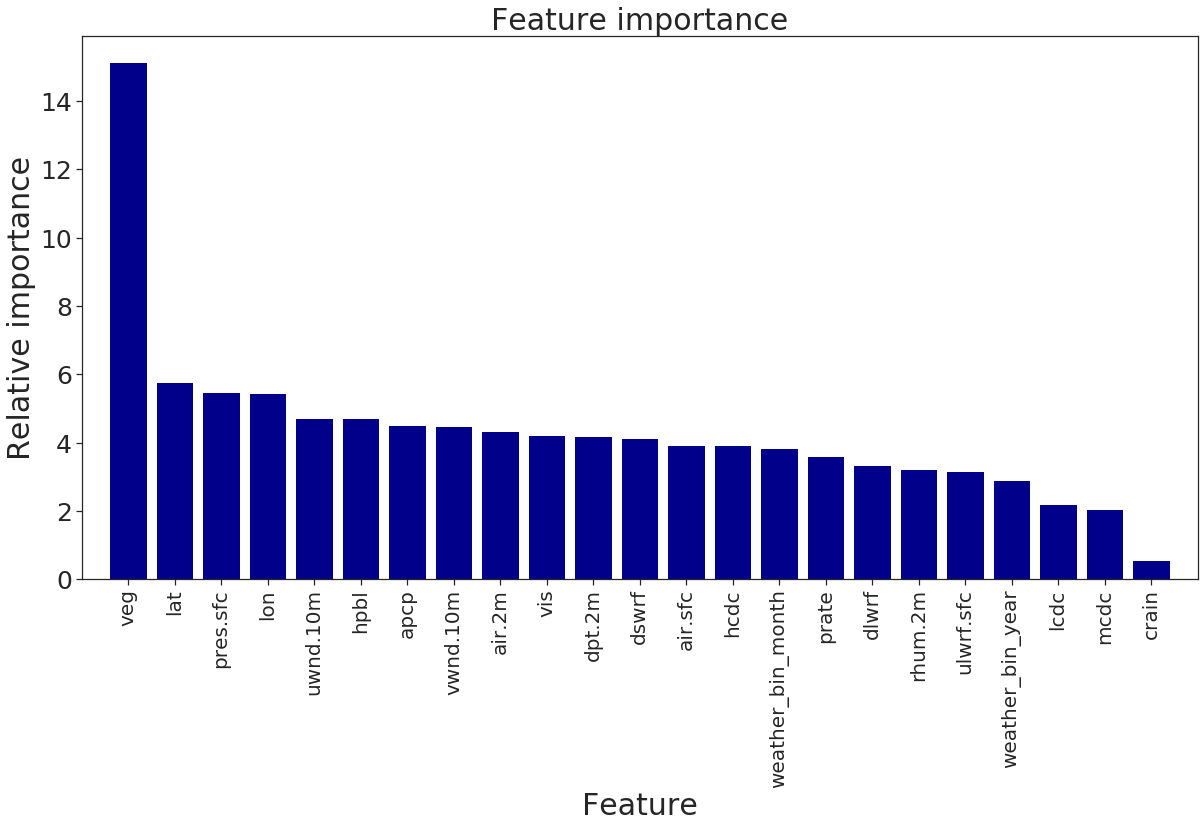

In [15]:
# Retrain catboost model on new train-test split with new hyperparameters
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)
          
catboost_model = CatBoostClassifier(**known_params)
catboost_model.fit(x_train, y_train)

plot_relative_feature_importance(catboost_model, data, x_test, 20)

Interesting, some features which were expected to be important are fairly far down on the list. For example: air temperature at 2 meters and u/v components of wind speed. Before we go throwing variables away or trying to reduce dimensionality let's do some hyperparameter optimization and see if the relative feature importances change.

## Hyperparameter optimization: class weight
We sampled our data so we have the same number of positive and negative results so we may not need a class weight. Let's try a few values and see how if effects our false positive and false negative rates.

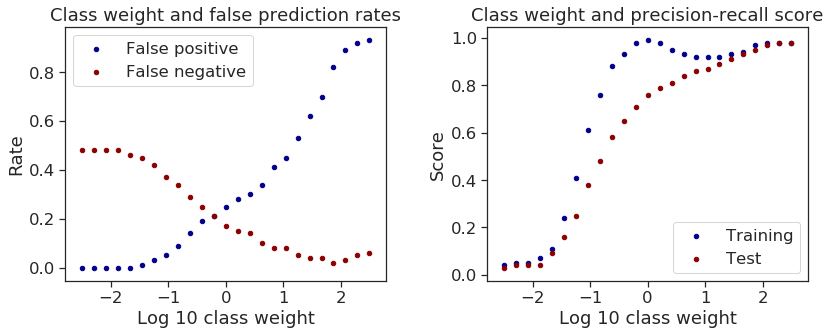

In [16]:
class_weights = np.logspace(-2.5, 2.5, num=25, base=10)

model_scores = tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
)

plot_class_weight_tuning_results(model_scores)

Interesting. We can use larger class weights to drive down the false negative rate at the expense of false positives. Looking at the clearly sigmoidal precision recall curve, the optimum value looks like it's around 1. Before just using no weight, let's try this again with a narrower range.

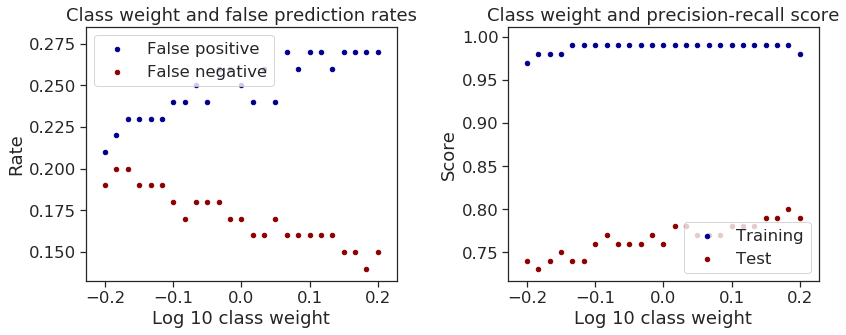

In [17]:
class_weights = np.logspace(-0.2, 0.2, num=25, base=10)

model_scores = tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
)

plot_class_weight_tuning_results(model_scores)

Wow, this one is actually pretty subjective... I'm calling it somewhere between one and three. Let's use 1.8 for now. This should give us ~90/85 precision-recall and put our false positive and false negative rates at 0.25 and ~0.1 respectively.

In [18]:
known_params = {
    'random_state': rand_seed,
    'thread_count': max_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78
}

**Note:** Important to keep in mind here that we can tune our false positive/false negative rates easily with this hyperparameter.

In [19]:
# Train model with new class weight
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

In [20]:
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with scoring function & class weight',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

,Description,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,Default CatBoost model,5,0.99 +/- 0.003,0.73 +/- 0.025,0.26 +/- 0.018,0.2 +/- 0.033
1,CatBoost model with Cosine scoring function,5,0.99 +/- 0.002,0.75 +/- 0.028,0.23 +/- 0.017,0.2 +/- 0.038
2,CatBoost with scoring function & class weight,5,0.97 +/- 0.001,0.79 +/- 0.013,0.3 +/- 0.007,0.16 +/- 0.005


## Hyperparameter tuning: learning rate and tree count

First, let's try taking one sample of the full dataset and then using RandomizedSearchCV to try and find the best values for learning rate and tree count.

In [21]:
param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,100)
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

best_model, random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 3 min. for 100 candidate parameter settings.


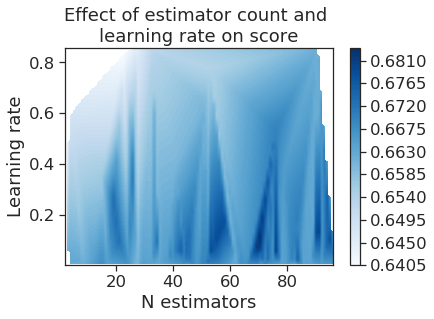

In [22]:
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

Surprised by how 'rough' hyperparameter space is. Let's keep the winning numbers and save the scores to our log.

In [23]:
best_learning_rate = rand_search_results.iloc[0]['param_learning_rate']
best_n_estimators = rand_search_results.iloc[0]['param_n_estimators']

known_params = {
    'random_state': rand_seed,
    'thread_count': classifier_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

# Train model with new hyperparameters
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

# Add results to score history dataframe
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with n estimators and learning rate',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

,Description,n,Training score +/- STD,Test score +/- STD,False positive rate +/- STD,False negative rate +/- STD
0,Default CatBoost model,5,0.99 +/- 0.003,0.73 +/- 0.025,0.26 +/- 0.018,0.2 +/- 0.033
1,CatBoost model with Cosine scoring function,5,0.99 +/- 0.002,0.75 +/- 0.028,0.23 +/- 0.017,0.2 +/- 0.038
2,CatBoost with scoring function & class weight,5,0.97 +/- 0.001,0.79 +/- 0.013,0.3 +/- 0.007,0.16 +/- 0.005
3,CatBoost with n estimators and learning rate,5,0.81 +/- 0.007,0.77 +/- 0.024,0.36 +/- 0.018,0.19 +/- 0.023


Now, just for fun, let's see how our winning values for number of estimators and learning rate vary across repeated trials with different sample of the data.

In [ ]:
param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,100)
}

scores = []
learning_rates = []
n_estimators = []

itterations = 10

for i in range(itterations):
    # Resample and train-test split data
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 
    
    best_model, random_search = tune_hyperparameters(
        known_params,
        param_dist, 
        x_train, 
        y_train, 
        optimization_jobs, 
        search_iterations, 
        search_scoring_func
    )
    
    rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()
    winner = rand_search_results[rand_search_results['rank_test_score'] == 1]
    avg_score = winner.iloc[0]['mean_test_score']
    learning_rate = winner.iloc[0]['param_learning_rate']
    n_estimator = winner.iloc[0]['param_n_estimators']
    
    scores.append(avg_score)
    learning_rates.append(learning_rate)
    n_estimators.append(n_estimator)
    
    i += 1

In [ ]:
x = n_estimators
y = learning_rates
z = scores
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Winning estimator count and\n learning rate vs score")
plt.colorbar()
plt.show()

## Hyperparameter tuning: tree depth and L2 coefficient

In [ ]:
param_dist = {
    'depth': range(1, 21, 1),
    'l2_leaf_reg': np.linspace(0, 10, 101)
}

best_model, random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

In [ ]:
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

x = rand_search_results['param_depth']
y = rand_search_results['param_l2_leaf_reg']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Tree depth")
plt.ylabel("L2 coefficient")
plt.title("Effect of tree depth and \nL2 coefficient on score")
plt.colorbar()
plt.show()

Again, store winning parameters in dictionary and add score results to log.

In [ ]:
best_depth = rand_search_results.iloc[0]['param_depth']
best_l2_leaf_reg = rand_search_results.iloc[0]['param_l2_leaf_reg']

known_params = {
    'random_state': rand_seed,
    'thread_count': classifier_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators,
    'depth': best_depth,
    'l2_leaf_reg': best_l2_leaf_reg
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

# Train model with new hyperparameters
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

# Add results to score history dataframe
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with depth and L2 coefficient',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

## Final model: feature importance

In [ ]:
best_model = CatBoostClassifier(**known_params)
best_model.fit(x_train, y_train)

plot_relative_feature_importance(catboost_model, data, x_test, 20)

## Final model: effect of feature count

In [ ]:
train_scores = list()
test_scores = list()

feature_names = np.array(list(data))
importances = catboost_model.feature_importances_
indices = np.argsort(importances)[::-1]

for n in range(1,(len(feature_names) + 1)):
    # grab top n feature names
    top_n_features = feature_names[indices[0:n]]

    # rebuild training and test sets with feature subset
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    data_subset = data[top_n_features]
    x_train_subset, x_test_subset, y_train_subset, y_test_subset  = train_test_split(data_subset, targets)

    # instantiate and train classifier
    catboost_model = CatBoostClassifier(**known_params)
    catboost_model.fit(x_train_subset, y_train_subset)

    # report score for feature subset
    training_score = average_precision_score(catboost_model.predict(x_train_subset), y_train_subset)
    test_score = average_precision_score(catboost_model.predict(x_test_subset), y_test_subset)
    
    train_scores.append(training_score)
    test_scores.append(test_score)
    
    #print('Top {} features, precision-recall score train/test: {}/{}'.format(n,np.round(training_score,2),np.round(test_score,2)))

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(1,(len(feature_names) + 1)), train_scores, s=20, c='darkblue', label='Training data')
ax.scatter(range(1,(len(feature_names) + 1)), test_scores, s=20, c='darkred', label='Test data')
plt.legend(loc='upper right')
plt.title("Model performance and feature count")
plt.xlabel("N features")
plt.ylabel("Avg. precision-recall score")
plt.show()

## Final model: robustness

In [ ]:
top_n_features

In [ ]:
train_scores = list()
test_scores = list()
false_neg_rates = list()
false_pos_rates = list()

# grab top n feature names
indices = np.argsort(importances)[::-1]
top_n_features = feature_names[indices[0:7]]
print(feature_names)
print(indices)
print(indices[0:7])
print(top_n_features)
print(importances)

for i in range(0, 10):
    # rebuild training and test sets with feature subset
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    data_subset = data[top_n_features]
    x_train, x_test, y_train, y_test = train_test_split(data_subset.values, targets.values)

    # instantiate and train classifier
    catboost_model = CatBoostClassifier(**known_params)
    catboost_model.fit(x_train, y_train)

    predicted_y = catboost_model.predict(x_test)
    
    training_score = average_precision_score(catboost_model.predict(x_train), y_train)
    test_score = average_precision_score(predicted_y, y_test)

    train_scores.append(training_score)
    test_scores.append(test_score)
    
    false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_model, x_test, y_test)

    false_neg_rates.append(false_neg_rate)
    false_pos_rates.append(false_pos_rate)

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.kdeplot(train_scores, label="Training data", shade=True, color="darkblue")
ax = sns.kdeplot(test_scores, label="Test data", shade=True, color="darkred")
ax.set_title("Precision-recall score distributions")
ax.set(xlabel='Avg. precision-recall score', ylabel='Density')
plt.legend()
plt.legend(loc='upper left')

plt.show()

In [ ]:
ax = sns.kdeplot(false_neg_rates, label="False negative", shade=True, color="darkblue")
ax = sns.kdeplot(false_pos_rates, label="False positive", shade=True, color="darkred")
ax.set_title("False positive and negative rates")
ax.set(xlabel='Rate', ylabel='Density')
plt.legend()

plt.show()

In [ ]:
plt.scatter(false_neg_rates, false_pos_rates, s=5)
plt.xlabel("False negative rate")
plt.ylabel("False positive rate")
plt.title("False positive vs false negative rate")

plt.show()

## Final results

In [ ]:
model_score_comparisions

In [ ]:
model_score_history